In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd 
from pandas import DataFrame
import math
import numpy as np
from numpy import genfromtxt
import sklearn
from collections import Counter
import sys
import matplotlib
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

## **Training Data**
Data is read from the file given and pre-processing is done. Data attributes having more than 80% values as NaN are dropped. For categorical features, the NaN values are replaced with the mode of the column whereas for numerical features, the NaN values are replaced with the mean of the column. Train data is splitted into train and validation data.

In [0]:
data=pd.read_csv('/content/drive/My Drive/Assignment1 Dataset//Datasets/q3/train.csv')
validation_data = data.loc[:200, :'SaleCondition']
validation_label = data.loc[:200, 'SalePrice']
train_data = data.loc[200:,:]
train_label = data.loc[200:, 'SalePrice']
data1 = data.loc[200:,:]
validation_data = validation_data.drop(['Id'],axis=1)
train_data = train_data.drop(['Id'],axis=1)

validation_data.dropna(thresh=validation_data.shape[0]*0.8,how='all',axis=1, inplace=True)
train_data.dropna(thresh=train_data.shape[0]*0.8,how='all',axis=1, inplace=True)
data = train_data
for col in data.columns:
  li = data[col].tolist()
  if(isinstance(li[0],str)):
    data[col].fillna(data[col].mode()[0], inplace=True)
  else:
    data[col].fillna(data[col].mean(), inplace=True)

test_data = validation_data
for col in test_data.columns:
  li = test_data[col].tolist()
  if(isinstance(li[0],str)):
    test_data[col].fillna(test_data[col].mode()[0], inplace=True)
  else:
    test_data[col].fillna(test_data[col].mean(), inplace=True)

# validation_data
validation_label
test_label = validation_label.to_numpy()
# print(test_data)
data2 = train_label
data = train_data
# print(data1)
global_avg = data['SalePrice'].mean()
# print(data2)
# train_data
# train_label
# data

## **Node of Decision Tree**
The structure of a node are:
*   attribute name selceted on that node
*   decision on that node
*   selling price predicted at leaf level nodes
*   left child
*   right child







In [0]:
class Node: 
  def __init__(self, attribute, split, ans):
    self.attr = attribute
    self.split_point = split
    self.answer = ans
    self.left = None
    self.right = None

## **Build Tree**
*   The tree is built recursively.
*   The attribute with maximum gain is selected and made it the root 
    node and recurse the funciton for all its unique value.

We stop at three conditions
1.  If there are rows only of one type of output
2.  If height of the tree is greater than or equal to ten
3.  If the number of rows in one side is less than fifty

In that case we make decision on the probablity of outcome till that node.



In [0]:
def makeTree(data, level):
  if(level >= 10):
    avg = data['SalePrice'].mean()
    root = Node('SalePrice',-1,avg)
    return root
  if(len(data.index)==0):
    root = Node('SalePrice',-1,global_avg)
    return root
  if(len(data.index)<=50):
    avg = data['SalePrice'].mean()
    root = Node('SalePrice',-1,avg)
    return root
  node_attr, node_split = find_node(data)
  root = Node(node_attr, node_split, 0)
  left_dataframe = data[data[node_attr]<=node_split]
  left_dataframe = left_dataframe.drop([node_attr],axis=1)
  right_dataframe = data[data[node_attr]>node_split]
  right_dataframe = right_dataframe.drop([node_attr],axis=1)
  root.left = makeTree(left_dataframe, level+1)
  root.right = makeTree(right_dataframe, level+1)
  return root

In [0]:
def rms(dataset, element):
  mean_sp = dataset['SalePrice'].mean()
  temp = (dataset['SalePrice'] - mean_sp)**2
  sum1 = temp.values.sum()
  sum1 = sum1/(len(data.index))
  return math.sqrt(sum1)

In [0]:
def split_n_rms(left_dataset, right_dataset, element):
  left_rms = rms(left_dataset, element)
  right_rms = rms(right_dataset, element)
  left_rms_length = len(left_dataset.index)
  right_rms_length = len(right_dataset.index)
  total_rms_length = left_rms_length + right_rms_length
  rms_value = ((left_rms_length/total_rms_length)*left_rms) + ((right_rms_length/total_rms_length)*right_rms)
  return rms_value

### Choosing attribute with maximum gain
*   The attribute with maximum gain, that is one giving the least root mean square error is found and returned.
*   This is done seperately for categorical and numerical attributes.
*   The attribute chosen and it's split point is returned.


In [0]:
def find_node(data):
  min_rms = sys.maxsize
  split_attr = ""
  split_point = 0
  for col in data.columns:
    if(col == 'SalePrice'):
      break
    li = data[col].tolist()
    li1 = list(set(li))
    if(isinstance(li1[0],str)):
      for element in li1:
        left_dataset = data[data[col] == element]
        right_dataset = data[data[col] != element]
        rms_value = split_n_rms(left_dataset, right_dataset, element)
        if(rms_value<=min_rms):
          split_attr = col
          split_point = element
          min_rms = rms_value
    else:
      for i in range(0,len(li1)-1):
        element = (li1[i] + li1[i+1])/2
        left_dataset = data[data[col]<=element]
        right_dataset = data[data[col]>element]
        rms_value = split_n_rms(left_dataset, right_dataset, element)
        if(rms_value<=min_rms):
          split_attr = col
          split_point = element
          min_rms = rms_value
        
  return split_attr, split_point

### **Searching**
The tree is searched to make the prediction.
At every level, the attribute value is checked and a decision is made based on the value at that point. On reaching the leaf level, the Selling Price stored is predicted as output.

In [0]:
def search(root, row):
  if(root == None):
    return
  if(root.left == None and root.right==None):
    return root.answer
  
  attribute = root.attr
  li = data[attribute].tolist()
  if(isinstance(li[0],str)):
    value = row[attribute]
    if(value == root.split_point):
      return search(root.left,row)
    else:
      return search(root.right,row)
  else:
    value = row[attribute]
    if(value <= root.split_point):
      return search(root.left,row)
    else:
      return search(root.right,row)

## **Predictions**
The prediction is made and tested. 
*   **r2 score** of **0.653** is obtained.
*   **Mean Squared Error** is found as **2442363070.30**
*   **Mean Absolute Error** is found as **30574.75**
*   The graph is is plotted showing the deviation of the actual      Selling Price from the predicted one.





r2 score 0.6532707128946105
Mean Squared Error 2442363070.3042088
Mean Absolute Error 30574.755632790777


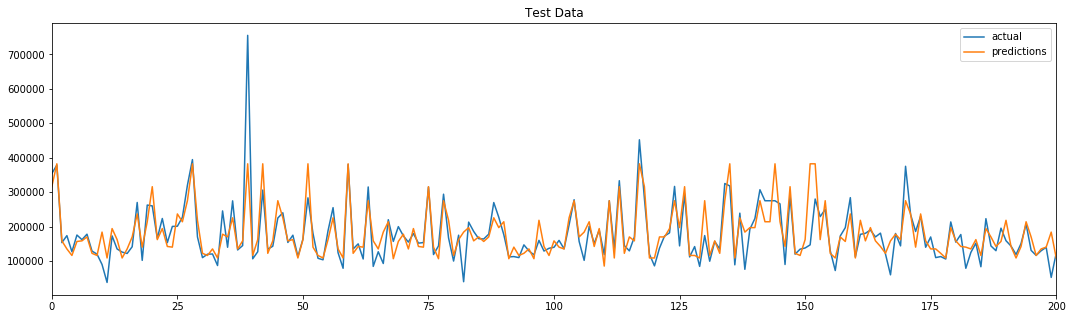

In [42]:
min_rms = sys.maxsize
root = makeTree(data, 0)
li = []
for i in range(0,len(test_data)):
  row = test_data.iloc[i]
  ans = search(root,row)
  li.append(ans)
  # print("ans: ",ans)
predicted_label = np.asarray(li)
print("r2 score",r2_score(test_label, predicted_label))
print ("Mean Squared Error",mean_squared_error(test_label, predicted_label))
print ("Mean Absolute Error",mean_absolute_error(test_label, predicted_label))
plot_df = pd.DataFrame({"actual": test_label, "predictions": predicted_label})
plot_df.plot(figsize=(18, 5), title="Test Data")

## **Predictions on Test data**
The prediction is made and tested. 
*   **r2 score** of **0.780** is obtained.
*   **Mean Squared Error** is found as **1162304856.48**
*   **Mean Absolute Error** is found as **24423.37**
*   The graph is is plotted showing the deviation of the actual      Selling Price from the predicted one.





In [0]:
data=pd.read_csv('/content/drive/My Drive/Assignment1 Dataset//Datasets/q3/train.csv')
test_data=pd.read_csv('/content/drive/My Drive/Assignment1 Dataset//Datasets/q3/test.csv')
test_label1=pd.read_csv('/content/drive/My Drive/Assignment1 Dataset//Datasets/q3/test_labels.csv', header=None)
test_label_list = test_label1[1].tolist()
test_label = np.asarray(test_label_list)

data = data.drop(['Id'],axis=1)
test_data = test_data.drop(['Id'],axis=1)
data.dropna(thresh=data.shape[0]*0.8,how='all',axis=1, inplace=True)
test_data.dropna(thresh=test_data.shape[0]*0.8,how='all',axis=1, inplace=True)

for col in data.columns:
  li = data[col].tolist()
  if(isinstance(li[0],str)):
    data[col].fillna(data[col].mode()[0], inplace=True)
  else:
    data[col].fillna(data[col].mean(), inplace=True)

data1 = data
data2 = data['SalePrice']
data1 = data1.drop(['SalePrice'],axis=1)
# print(data2)
for col in test_data.columns:
  li = test_data[col].tolist()
  if(isinstance(li[0],str)):
    test_data[col].fillna(test_data[col].mode()[0], inplace=True)
  else:
    test_data[col].fillna(test_data[col].mean(), inplace=True)
# print(data1.info())
# test_data.info()
# data.info()
global_avg = data['SalePrice'].mean()
# print(data)

r2 score 0.780066653515418
Mean Squared Error 1162304856.4848354
Mean Absolute Error 24423.373653227245


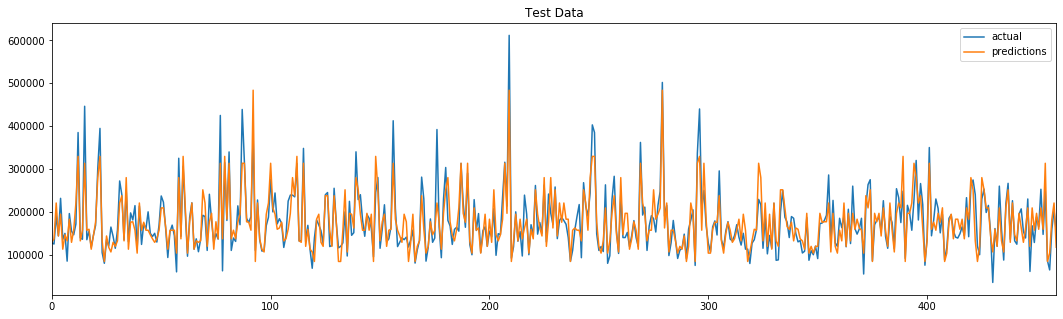

In [45]:
min_rms = sys.maxsize
root = makeTree(data, 0)
li = []
for i in range(0,len(test_data)):
  row = test_data.iloc[i]
  ans = search(root,row)
  li.append(ans)
  # print("ans: ",ans)
predicted_label = np.asarray(li)
print("r2 score",r2_score(test_label, predicted_label))
print ("Mean Squared Error",mean_squared_error(test_label, predicted_label))
print ("Mean Absolute Error",mean_absolute_error(test_label, predicted_label))
plot_df = pd.DataFrame({"actual": test_label, "predictions": predicted_label})
plot_df.plot(figsize=(18, 5), title="Test Data")

## **Using scikit-learn’s Decision Tree**

In [0]:
le = LabelEncoder()
for col in test_data.columns:
  li = test_data[col].tolist()
  if(isinstance(li[0],str)):
    data1[col]= le.fit_transform(data1[col]) 
    test_data[col] = le.fit_transform(test_data[col])

regressor = DecisionTreeRegressor(random_state=0)
train1 = regressor.fit(data1,data2)
predictions = regressor.predict(test_data)
print("r2 score",r2_score(test_label, predictions))
print ("Mean Squared Error",mean_squared_error(test_label, predictions))
print ("Mean Absolute Error",mean_absolute_error(test_label, predictions))


r2 score 0.6913723258794027
Mean Squared Error 1631037085.597826
Mean Absolute Error 28816.25434782609


## **Comparison**
We make a comparison of the performances between the Decision Tree Regressor module of sklearn vs our own model.
*   Using the Decision Tree Regressor module of sklearn, we get a r2 score of **0.691**. We had seen that we got a r2 score of **0.779** using our own model.
*   Decision Tree Regressor module of sklearn gives a Mean Squared Error  of **1631037085.59**. We had seen that we got a Mean Squared Error of **1165875337.62** using our own model.
*   Decision Tree Regressor module of sklearn gives a Mean Absolute Error  of **28816.254**. We had seen that we got a Mean Absolute Error of **24423.37** using our own model.

**Thus, we can conclude that our model performs better.**